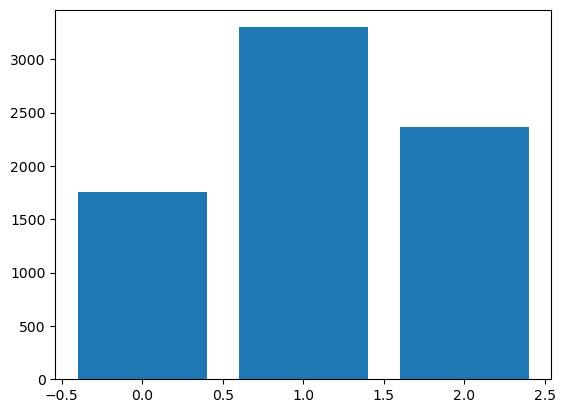

45
   Rating  Price  Reviews  Size  Installs  Days_since_last_update
0     4.1    0.0      159  19.0     10000                     213
1     3.9    0.0      967  14.0    500000                     205
2     4.7    0.0    87510   8.7   5000000                       7
3     4.5    0.0   215644  25.0  50000000                      61
4     4.3    0.0      967   2.8    100000                      49


In [1]:
%run ./ESE527_project_setup.ipynb
%run ./Metrics.py

## Classification with outlier detection

### Split dataset

In [2]:
features=data_db.drop(['Rating', 'Rating Interval'],axis=1)
label=data_db['Rating Interval']
standardized_features=Standardization(features)
train_X,test_X,train_Y,test_Y=train_test_split(standardized_features,label,test_size=0.2,random_state=527)
#smote = SMOTE()
# Fit and apply SMOTE
#train_X, train_Y = smote.fit_resample(train_X, train_Y)

## XGBoost

In [3]:
def objective(trial):
    """
    #首先使用params传递模型参数, 选定Xgboost模型后
    使用 3-fold cross validation与optuna优化器得到最优参数
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'booster':trial.suggest_categorical('booster',['gbtree']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),}
    model = XGBClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get the best parameters
best_params = study.best_params
clf_XGB= XGBClassifier(**best_params)
clf_XGB=clf_XGB.fit(train_X, train_Y)
y_pred_XGB=clf_XGB.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred_XGB)
print("Accuracy of XGBoost: ",accuracy)

[I 2024-11-05 14:04:39,279] A new study created in memory with name: no-name-24e735dd-9856-42d1-9cc0-d50f7328065f


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-05 14:04:44,100] Trial 0 finished with value: 0.5191812389860377 and parameters: {'n_estimators': 152, 'max_depth': 14, 'booster': 'gbtree', 'learning_rate': 0.06151666997487805}. Best is trial 0 with value: 0.5191812389860377.
[I 2024-11-05 14:04:45,018] Trial 1 finished with value: 0.48881659211061407 and parameters: {'n_estimators': 55, 'max_depth': 5, 'booster': 'gbtree', 'learning_rate': 0.03453059378480578}. Best is trial 0 with value: 0.5191812389860377.
[I 2024-11-05 14:04:54,525] Trial 2 finished with value: 0.5128100854005694 and parameters: {'n_estimators': 190, 'max_depth': 16, 'booster': 'gbtree', 'learning_rate': 0.031036695832290743}. Best is trial 0 with value: 0.5191812389860377.
[I 2024-11-05 14:04:58,153] Trial 3 finished with value: 0.5011522299037549 and parameters: {'n_estimators': 56, 'max_depth': 14, 'booster': 'gbtree', 'learning_rate': 0.007565241550013706}. Best is trial 0 with value: 0.5191812389860377.
[I 2024-11-05 14:05:00,337] Trial 4 finished

In [6]:
importances = clf_XGB.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Genres_Simulation;Action & Adventure 0.024725
 2) Genres_Educational;Education   0.021972
 3) Genres_Travel & Local          0.020440
 4) Category_HEALTH_AND_FITNESS    0.020167
 5) Installs                       0.019446
 6) Category_BOOKS_AND_REFERENCE   0.018604
 7) Category_LIBRARIES_AND_DEMO    0.017987
 8) Category_HOUSE_AND_HOME        0.016996
 9) Genres_Educational             0.016323
10) Category_PARENTING             0.016160
11) Genres_Education               0.015845
12) Category_PERSONALIZATION       0.015729
13) Category_MAPS_AND_NAVIGATION   0.015718
14) Genres_Word                    0.015705
15) Content Rating_Mature 17+      0.014830
16) Category_BEAUTY                0.014802
17) Category_SHOPPING              0.014447
18) Category_MEDICAL               0.014268
19) Reviews                        0.014254
20) Category_COMMUNICATION         0.014018
21) Category_LIFESTYLE             0.013819
22) Category_EDUCATION             0.013635
23) Category_EVENTS       

Accuracy: 0.5602981029810298
Precision: 0.5587196418727662
Recall: 0.5602981029810298
F1 Score: 0.5570389175860072


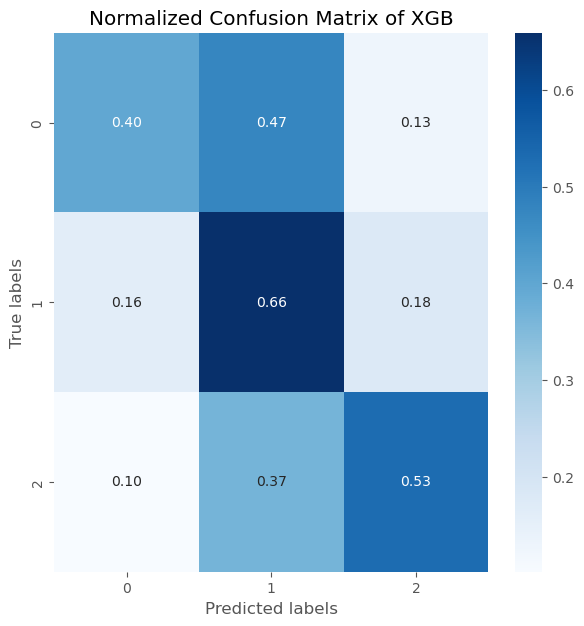

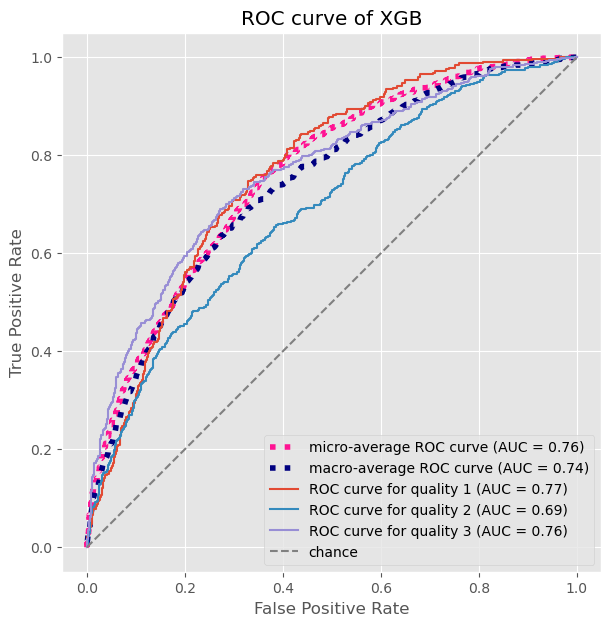

In [7]:
cm(test_X,test_Y,clf_XGB,'XGB',['0','1','2'])
ROC(train_Y,test_Y,test_X,clf_XGB,'XGB')

#### Shap values for each Rating Interval

In [10]:
explainer = shap.Explainer(clf_XGB,train_X)
shap_values_XGB = explainer(train_X)

100%|===================| 17643/17703 [02:03<00:00]        

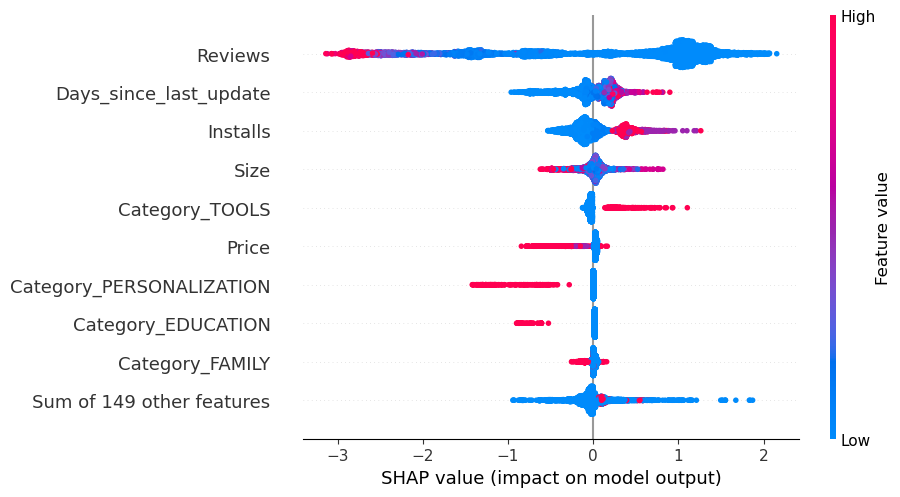

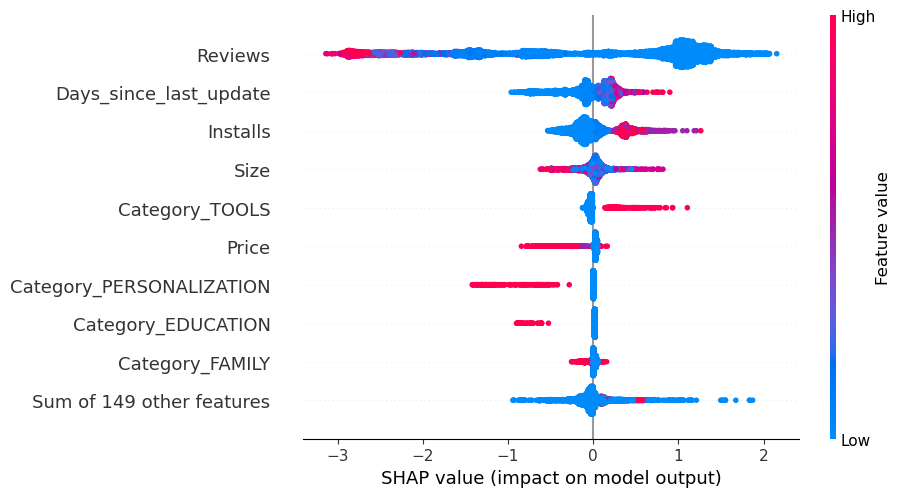

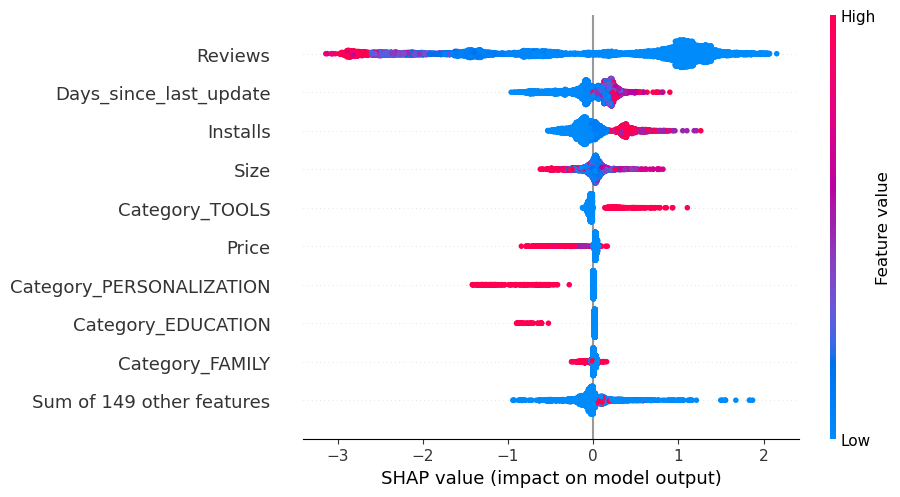

In [11]:
# summarize the effects of all the features
plt.rcParams['figure.figsize']=(8,4)
for i in range(0,3):
    shap.plots.beeswarm(shap_values_XGB[:,:,0])

## Lightgbm


In [8]:
def objective(trial):
    params= {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
clf_lgbm=lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(train_X, train_Y)
y_pred_lgbm=clf_lgbm.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred_lgbm)
accuracy

[I 2024-11-05 14:34:49,007] A new study created in memory with name: no-name-26ef5804-9734-410f-a138-9224652877d6


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.6134395851984089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6134395851984089
[LightGBM] [Warning] bagging_fraction is set=0.6830564582848747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6830564582848747
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6134395851984089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6134395851984089
[LightGBM] [Warning] bagging_fraction is set=0.6830564582848747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6830564582848747
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds

0.5548780487804879

#### Shap values for each Rating Interval

In [13]:
explainer = shap.Explainer(clf_lgbm,train_X)
shap_values_lgbm = explainer(train_X)

100%|===================| 17701/17703 [09:03<00:00]        

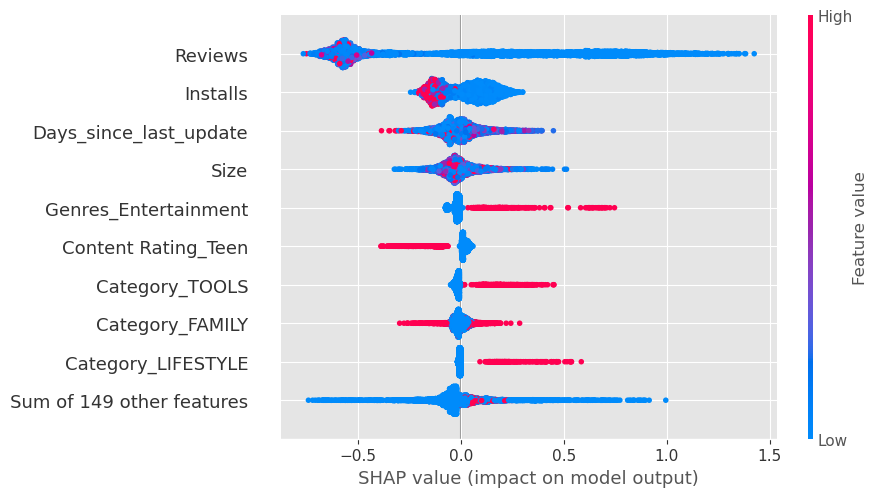

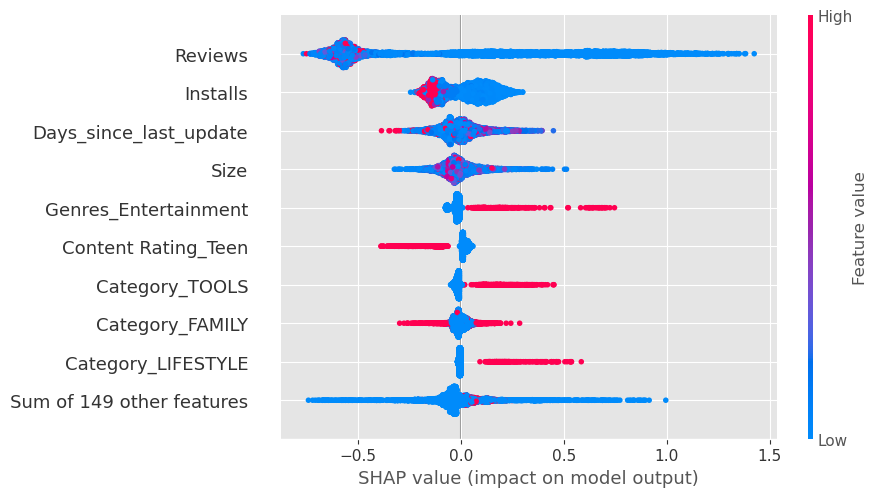

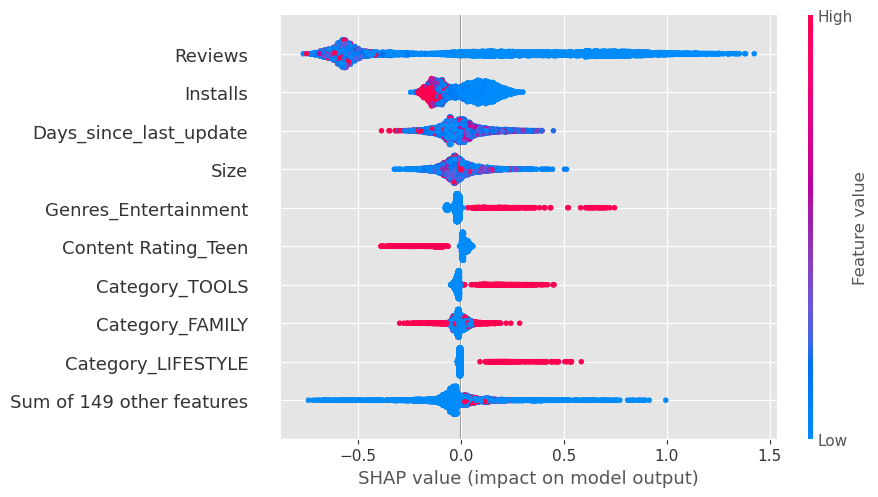

In [14]:
# summarize the effects of all the features
plt.rcParams['figure.figsize']=(8,4)
for i in range(0,3):
    shap.plots.beeswarm(shap_values_lgbm[:,:,0])

In [23]:
importances = clf_lgbm.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Reviews                        1686.000000
 2) Days_since_last_update         1640.000000
 3) Size                           1524.000000
 4) Installs                       852.000000
 5) Price                          226.000000
 6) Content Rating_Everyone        92.000000
 7) Category_FAMILY                89.000000
 8) Genres_Entertainment           80.000000
 9) Category_GAME                  80.000000
10) Category_TOOLS                 72.000000
11) Content Rating_Teen            72.000000
12) Genres_Education               68.000000
13) Category_PERSONALIZATION       61.000000
14) Genres_Casual                  60.000000
15) Category_COMMUNICATION         57.000000
16) Content Rating_Mature 17+      54.000000
17) Category_HEALTH_AND_FITNESS    52.000000
18) Category_MEDICAL               52.000000
19) Category_DATING                47.000000
20) Genres_Racing                  47.000000
21) Genres_Action                  46.000000
22) Category_BOOKS_AND_REFERENCE   46.000000
23

[LightGBM] [Warning] feature_fraction is set=0.6358313849883117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6358313849883117
[LightGBM] [Warning] bagging_fraction is set=0.7258434638856086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7258434638856086
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Accuracy: 0.5650406504065041
Precision: 0.5614921220174582
Recall: 0.5650406504065041
F1 Score: 0.5610137596567908


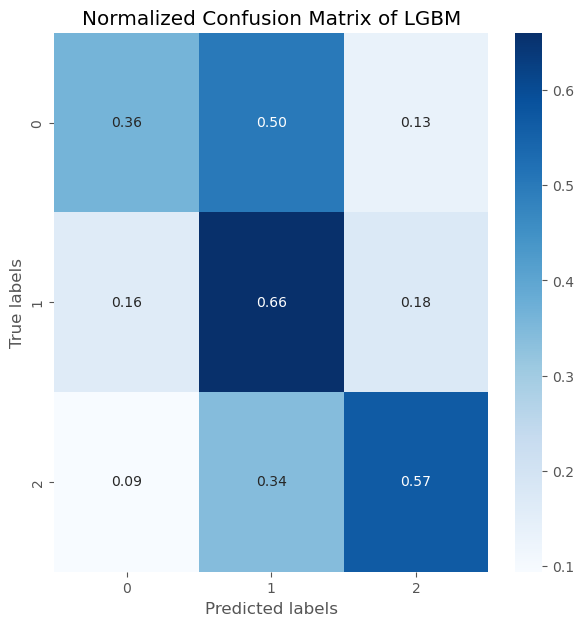

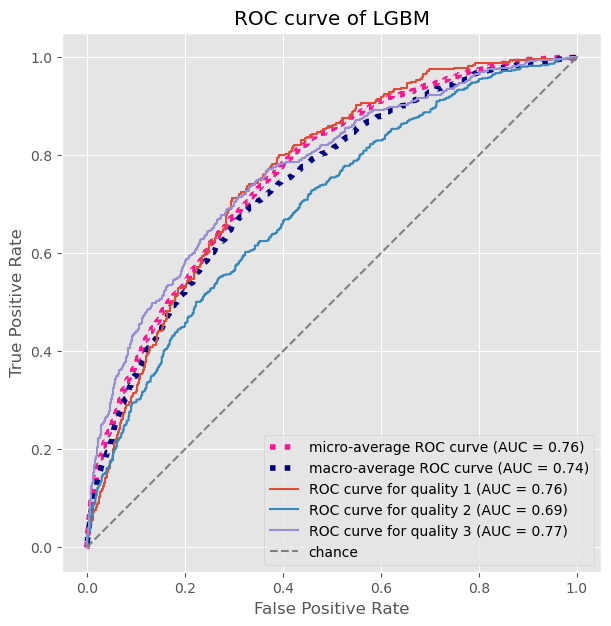

In [24]:
cm(test_X,test_Y,clf_lgbm,'LGBM',['0','1','2'])
ROC(train_Y,test_Y,test_X,clf_XGB,'LGBM')

## Catboost

In [25]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'depth': trial.suggest_int('depth', 1, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'task_type':trial.suggest_categorical('task_type',['GPU']),
        'loss_function':trial.suggest_categorical('loss_function',['MultiClass'])
    }
    model = cat.CatBoostClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
clf_cat= cat.CatBoostClassifier(**best_params)
clf_cat.fit(train_X, train_Y)
y_pred_cat=clf_cat.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred_cat)
accuracy

[I 2024-10-30 20:12:57,075] A new study created in memory with name: no-name-ed5ca2c5-558b-46cc-a752-936115b201fc


  0%|          | 0/50 [00:00<?, ?it/s]

0:	learn: 1.0794589	total: 112ms	remaining: 14.6s
1:	learn: 1.0632703	total: 133ms	remaining: 8.6s
2:	learn: 1.0481952	total: 153ms	remaining: 6.53s
3:	learn: 1.0352152	total: 175ms	remaining: 5.55s
4:	learn: 1.0236752	total: 197ms	remaining: 4.97s
5:	learn: 1.0127629	total: 219ms	remaining: 4.57s
6:	learn: 1.0040967	total: 240ms	remaining: 4.26s
7:	learn: 0.9955865	total: 262ms	remaining: 4.02s
8:	learn: 0.9884316	total: 285ms	remaining: 3.87s
9:	learn: 0.9806590	total: 303ms	remaining: 3.67s
10:	learn: 0.9740296	total: 323ms	remaining: 3.52s
11:	learn: 0.9678756	total: 342ms	remaining: 3.39s
12:	learn: 0.9619104	total: 362ms	remaining: 3.29s
13:	learn: 0.9565520	total: 383ms	remaining: 3.2s
14:	learn: 0.9513225	total: 402ms	remaining: 3.11s
15:	learn: 0.9471487	total: 424ms	remaining: 3.04s
16:	learn: 0.9424586	total: 442ms	remaining: 2.96s
17:	learn: 0.9383274	total: 461ms	remaining: 2.89s
18:	learn: 0.9349527	total: 482ms	remaining: 2.84s
19:	learn: 0.9302734	total: 503ms	remaining

0.5589430894308943

In [26]:
importances = clf_cat.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Reviews                        26.118748
 2) Installs                       23.184375
 3) Days_since_last_update         16.862721
 4) Size                           12.113990
 5) Content Rating_Everyone        1.859901
 6) Price                          1.843607
 7) Category_GAME                  1.524764
 8) Genres_Education               1.292433
 9) Category_FAMILY                1.266860
10) Category_TOOLS                 1.126059
11) Category_HEALTH_AND_FITNESS    0.931632
12) Content Rating_Mature 17+      0.854314
13) Category_PERSONALIZATION       0.829166
14) Genres_Entertainment           0.751208
15) Content Rating_Teen            0.539311
16) Category_COMMUNICATION         0.538726
17) Genres_Lifestyle               0.464875
18) Category_BOOKS_AND_REFERENCE   0.449632
19) Genres_Health & Fitness        0.428484
20) Genres_Tools                   0.420274
21) Genres_Books & Reference       0.408420
22) Genres_Communication           0.354761
23) Genres_Personalization  

Accuracy: 0.5589430894308943
Precision: 0.5572853572142548
Recall: 0.5589430894308943
F1 Score: 0.5505009430409399


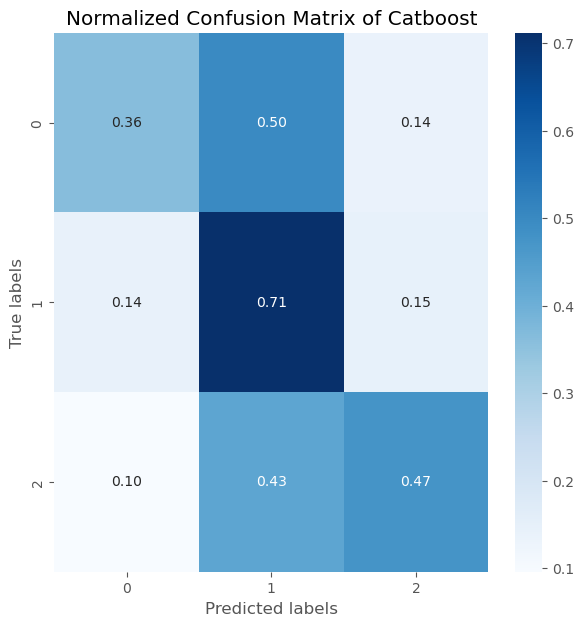

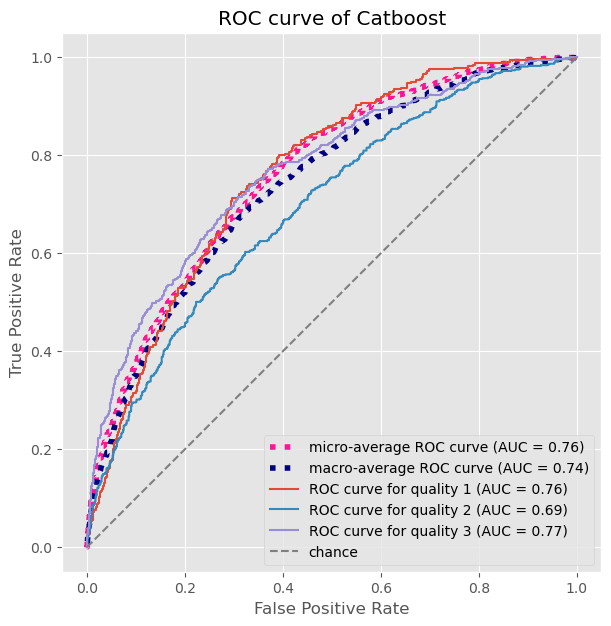

In [28]:
cm(test_X,test_Y,clf_cat,'Catboost',['0','1','2'])
ROC(train_Y,test_Y,test_X,clf_XGB,'Catboost')

In [ ]:
def weight(weight):
    new=[]
    for i in range(0,len(test_X)):
        Y=int(weight[0]*y_pred_XGB[i]+weight[1]*y_pred_lgbm[i]+weight[2]*y_pred_cat[i])
        new.append(round(Y,0))
    return new

In [29]:
def Voting():
    new=[]
    for i in range(0,len(test_X)):
        Y=statistics.mode([y_pred_XGB[i],y_pred_lgbm[i],int(y_pred_cat[i])])
        new.append(Y)
    return new

### Final Accuracy

In [30]:
accuracy=accuracy_score(test_Y,Voting())
print("The final accuracy is: ", round(accuracy,4))

The final accuracy is:  0.5705
